# Reproduce the Laplace package 
The Laplace package facilitates the application of Laplace approximations for entire neural networks, subnetworks of neural networks, or just their last layer. This project reproduces the Laplace package for learning purposes. </br>
This notebook shows how the reproduced Laplace can be used for parameter posterior approximation, hyper-parameter tuning, and prediction. Furthermore, the results are compared with Bayesian linear regression, and the Laplace package.
## References
[Laplace: Laplace approximations for Deep Learning.](https://github.com/AlexImmer/Laplace/tree/main)
```  
@inproceedings{laplace2021,
  title={Laplace Redux--Effortless {B}ayesian Deep Learning},
  author={Erik Daxberger and Agustinus Kristiadi and Alexander Immer 
          and Runa Eschenhagen and Matthias Bauer and Philipp Hennig},
  booktitle={{N}eur{IPS}},
  year={2021}
}
@inproceedings{dangel2020backpack,
    title     = {Back{PACK}: Packing more into Backprop},
    author    = {Felix Dangel and Frederik Kunstner and Philipp Hennig},
    booktitle = {International Conference on Learning Representations},
    year      = {2020},
    url       = {https://openreview.net/forum?id=BJlrF24twB}
}
```

In [18]:
import math

import torch 
import torch.nn as nn

import numpy as np 
import matplotlib.pyplot as plt

from LABDL.models import BayesianLinearRegression
from LABDL.data.generator import * 
from LABDL.laplace import FullLaplace, DiagLaplace
from LABDL.trainer.training import *

from laplace import Laplace

In [2]:
%reload_ext autoreload 
%autoreload 2

## Linear toy data
First, we set up the training data for the problem with observation noise ($\sigma=0.2$):

Text(0.5, 1.0, 'training samples, f(x) = 0.3x+(-0.7), sigma=0.2')

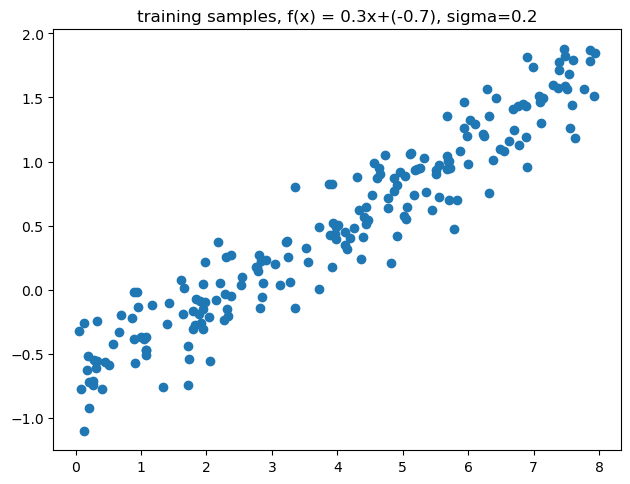

In [3]:
slope, bias = 0.3, -0.7
X_train, y_train, train_loader, X_test = get_linear_examples(slope=slope, bias=bias)
fig, axs = plt.subplots()
fig.tight_layout()
axs.plot(X_train, y_train, 'o')
axs.set_title(f"training samples, f(x) = {slope}x+({bias}), sigma=0.2")

## Models' set up: Bayesian linear regression, reproduced-Laplace, and Laplace.
As mentioned earlier, three models are tested and compared: the Bayesian linear regression, the Laplace reproduced in this project, and the Laplace package. 
### Bayesian linear regression
We can use the Bayesian linear regression to analytical compute the posterior, the predictive, and the marginal likelihood, i.e. the data evidence. 

In [29]:
blr = BayesianLinearRegression(X_train, y_train)

### Reproduced-Laplace and the Laplace
We use `pytorch` to train a simple linear layer with only two parameters, the weight and bias. The trained linear model will be our MAP estimate.  </br>
Then we set up and fit the Reproduced-Laplace and the Laplace model, whose Hessian is approximated by full GGN matrix.

In [30]:
model = nn.Linear(1, 1)
print(model)
# fit model to obtain the MAP estimate parameter, the parameters are normally centered-distributed.
loss = train(model, train_loader)
print(f"sumed MSE Loss after training: {loss}")
for name, params in model.named_parameters():
    print(name)
    print(params)

Linear(in_features=1, out_features=1, bias=True)
=============EPOCH 1==============
loss_train: 0.852
=============EPOCH 101==============
loss_train: 0.039
=============EPOCH 201==============
loss_train: 0.039
=============EPOCH 301==============
loss_train: 0.039
=============EPOCH 401==============
loss_train: 0.040
Finished Training.
sumed MSE Loss after training: 21.57667489722371
weight
Parameter containing:
tensor([[0.2988]], requires_grad=True)
bias
Parameter containing:
tensor([-0.6820], requires_grad=True)


In [31]:
la = FullLaplace(model, H_approximation='GGN')
la.fit(train_loader) 

In [32]:
latorch = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
latorch.fit(train_loader)

### Test
We examine the equality of the posterior, predictive posterior, and marginal likelihood of three models. </br>
Since we actually fit the based model with MLE estimate without the regularization of prior, the posterior mean of Laplace-approximated models fails the equality test when the absolute tolerance is set at `1e-3`.</br>
It further results in some deviation on the predictive posterior, and the marginal likelihood.

In [14]:
mean_blr = blr.mean.flatten()
pos_blr = blr.posterior_precision.detach().numpy()

mean_la = la.mean.detach().numpy()
pos_la = la.posterior_precision.detach().numpy()

mean_latorch = latorch.mean.detach().numpy()
pos_latorch = latorch.posterior_precision.detach().numpy()

np.testing.assert_allclose(pos_blr, pos_la, atol=1e-3)

np.testing.assert_allclose(mean_la, mean_latorch, atol=1e-3)
np.testing.assert_allclose(pos_la, pos_latorch, atol=1e-3)

np.testing.assert_allclose(mean_blr, mean_la, atol=1e-2)
np.testing.assert_allclose(mean_blr, mean_la, atol=1e-3)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.001

Mismatched elements: 2 / 2 (100%)
Max absolute difference: 0.00417286
Max relative difference: 0.00916409
 x: array([ 0.28115 , -0.625967], dtype=float32)
 y: array([ 0.28375 , -0.621794], dtype=float32)

In [33]:
pred_mean_blr, pred_var_blr = blr.predict(X_test)
pred_mean_blr, pred_var_blr = pred_mean_blr.flatten().detach().numpy(), pred_var_blr.flatten().detach().numpy()

pred_mean_la, pred_var_la = la.predict(X_test)
pred_mean_la, pred_var_la = pred_mean_la.flatten().detach().numpy(), pred_var_la.flatten().detach().numpy()

f_mean_latorch, f_var_latorch = latorch(X_test)
pred_var_latorch = f_var_latorch + torch.ones(1)
pred_mean_latorch, pred_var_latorch = f_mean_latorch.flatten().detach().numpy(), pred_var_latorch.flatten().detach().numpy()

np.testing.assert_allclose(pred_var_blr, pred_var_la, atol=1e-3)
np.testing.assert_allclose(pred_mean_la, pred_mean_latorch, atol=1e-3)
np.testing.assert_allclose(pred_var_la, pred_var_latorch, atol=1e-3)
np.testing.assert_allclose(pred_mean_blr, pred_mean_la, atol=1e-1) 
np.testing.assert_allclose(pred_mean_blr, pred_mean_la, atol=1e-2) 

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.01

Mismatched elements: 416 / 500 (83.2%)
Max absolute difference: 0.0140295
Max relative difference: 9.2584505
 x: array([-2.185264e+00, -2.174495e+00, -2.163726e+00, -2.152957e+00,
       -2.142188e+00, -2.131419e+00, -2.120650e+00, -2.109881e+00,
       -2.099112e+00, -2.088343e+00, -2.077574e+00, -2.066805e+00,...
 y: array([-2.176072e+00, -2.165293e+00, -2.154515e+00, -2.143736e+00,
       -2.132957e+00, -2.122179e+00, -2.111400e+00, -2.100622e+00,
       -2.089843e+00, -2.079065e+00, -2.068286e+00, -2.057507e+00,...

In [34]:
def plot(X_train, y_train, X_test, f_mu, pred_std):
    fig, axs = plt.subplots()
    fig.tight_layout()
    axs.plot(X_train, y_train, 'o')
    axs.plot(X_test, f_mu, 'o')
    axs.fill_between(X_test.flatten(), f_mu - 2*pred_std, f_mu + 2*pred_std, alpha=0.2)

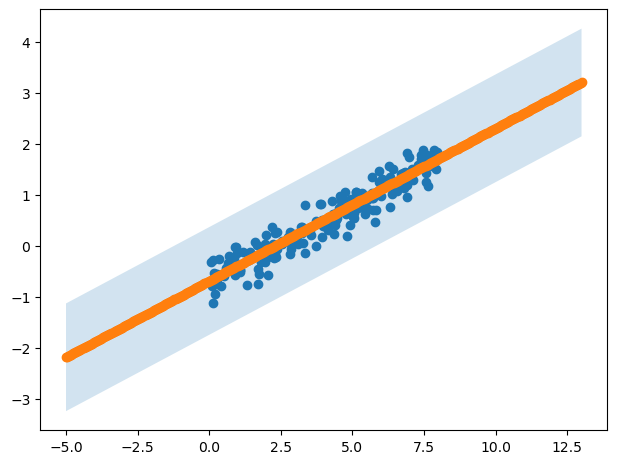

In [35]:
plot(X_train, y_train, X_test, pred_mean_la, np.sqrt(1/prior_precision_la))

### Hyper-parameter tuning with MLL

In [36]:
n_epochs = 1000

In [37]:
# Bayesian linear regression
log_sigma = torch.ones(1, requires_grad=True) # log std deviation of the regression Gaussian noise
log_prior_var = torch.ones(1, requires_grad=True) # log variance of parameter prior 
lr = 1e-1
optimizer = torch.optim.Adam([log_prior_var, log_sigma], lr=lr)
for epoch in range(n_epochs): 
    optimizer.zero_grad()
    neg_log_marg_lik = -blr.log_marginal_likelihood(log_prior_var.exp(), log_sigma.exp())
    neg_log_marg_lik.backward()
    optimizer.step()

In [38]:
# LA-based
log_sigma = torch.ones(1, requires_grad=True) # log std deviation of the regression Gaussian noise
log_prior_var = torch.ones(1, requires_grad=True) # log variance of parameter prior 
lr = 1e-1
optimizer = torch.optim.Adam([log_prior_var, log_sigma], lr=lr)
for epoch in range(n_epochs): 
    optimizer.zero_grad()
    neg_log_marg_lik = - la.log_marginal_likelihood(log_prior_var.exp(), log_sigma.exp())
    neg_log_marg_lik.backward()
    optimizer.step()

In [39]:
# laplace-torch
log_prior_, log_sigma_ = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior_, log_sigma_], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - latorch.log_marginal_likelihood(log_prior_.exp(), log_sigma_.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [40]:
print(log_sigma_.exp())
print(log_prior_.exp())

tensor([0.2162], grad_fn=<ExpBackward0>)
tensor([3.6008], grad_fn=<ExpBackward0>)


In [41]:
sigma_noise_blr = blr.sigma_noise.detach().numpy()
prior_precision_blr = blr.prior_precision.detach().numpy()

sigma_noise_la = la.sigma_noise.detach().numpy()
prior_precision_la = la.prior_precision.detach().numpy()

sigma_noise_latorch = log_sigma_.exp().detach().numpy()
prior_precision_latorch = log_prior_.exp().detach().numpy()

In [42]:
np.testing.assert_allclose(sigma_noise_latorch, sigma_noise_la, atol=1e-3)
np.testing.assert_allclose(prior_precision_latorch, prior_precision_la, atol=1e-3)

np.testing.assert_allclose(sigma_noise_blr, sigma_noise_la, atol=1e-3)
np.testing.assert_allclose(prior_precision_blr, prior_precision_la, atol=1e-1)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.1

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 0.20309639
Max relative difference: 0.05640304
 x: array([3.39771], dtype=float32)
 y: array([3.600806], dtype=float32)

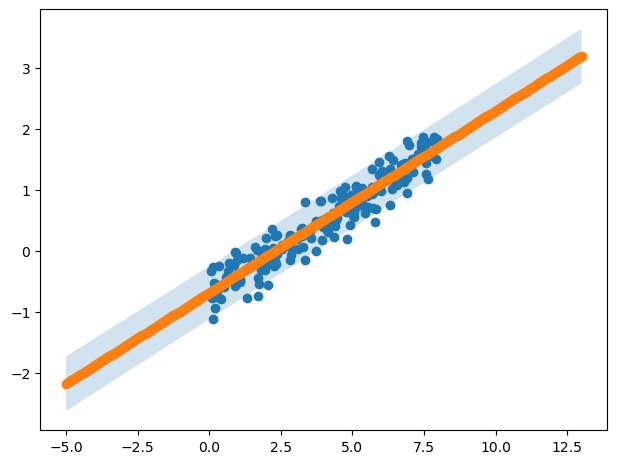

In [44]:
pred_mean_la, pred_var_la = la.predict(X_test)
pred_mean_la, pred_var_la = pred_mean_la.flatten().detach().numpy(), pred_var_la.flatten().detach().numpy()

plot(X_train, y_train, X_test, pred_mean_la, np.sqrt(pred_var_la))